## Thermal subduction, linear rheology:


The viscous rheology in this model is similar to the models described in the PhD thesis of Micheal Kaplan



**Keywords:** subduction, thermally-activated creep, 


**References:**


Kaplan, Michael. Numerical Geodynamics of Solid Planetary Deformation. Diss. University of Southern California, 2015.

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function
from unsupported.interfaces import markerLine2D

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

/root/underworld2/unsupported/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [2]:
#####
#Stubborn version number conflicts - need to figure out my Docker container runs an old version. For now...
#####
try:
    natsort.natsort = natsort.natsorted
except:
    natsort.natsort = natsort.natsort

Model name and directories
-----

In [3]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [4]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/checkpoint/ is empty


In [6]:
# setup summary output file (name above)
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[-1]  #This corresponds to the column you write time data to
    else:
        realtime = prevdata[prevdata.shape[0]-1, -1]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [7]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

In [8]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Set parameter dictionaries**

* Parameters are stored in dictionaries. 
* If starting from checkpoint, parameters are loaded using pickle
* If params are passed in as flags to the script, they overwrite 


In [9]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies



In [10]:
dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']

def save_pickles(dict_list, dict_names, dictPath):
    import pickle
    counter = 0
    for pdict in dict_list:
        myfile = os.path.join(dictPath, dict_names[counter])
        with open(myfile, 'wb') as f:
            pickle.dump(pdict, f)
        counter+=1


#ended up having to pretty much write a hard-coded function
#All dictionaries we want checkpointed will have to  be added here 
#and where the function is called
#Fortunately, this function is only called ONCE

def load_pickles():
    import pickle
    dirpath = os.path.join(checkpointPath, str(step))
    dpfile = open(os.path.join(dirpath, 'dp.pkl'), 'r')
    dp = pickle.load(dpfile)
#    #
    ndpfile = open(os.path.join(dirpath, 'ndp.pkl'), 'r')
    ndp = edict(pickle.load(ndpfile))
    #
    sffile = open(os.path.join(dirpath, 'sf.pkl'), 'r')
    sf = edict(pickle.load(sffile))
    #
    mdfile = open(os.path.join(dirpath, 'md.pkl'), 'r')
    md = edict(pickle.load(mdfile))
    return dp, ndp, sf, md

In [11]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


dp = edict({'LS':2900*1e3, #Scaling Length scale
            'depth':660*1e3, #Depth of domain
            'rho':3300.,  #reference density
            'g':9.8, #surface gravity
            'eta0':1.25e20, #reference viscosity
            'k':1e-6, #thermal diffusivity
            'a':3e-5, #surface thermal expansivity
            'R':8.314, #gas constant
            'TP':1673., #mantle potential temp (K)
            'TS':273., #surface temp (K)
            #Rheology - flow law paramters
            'Adf':3e-11, #pre-exp factor for diffusion creep
            #'Edf':1e5, #Total viscosity variation in the Kaplan model
            'Edf':3e5,
            'cm':40e6, #mantle cohesion in Byerlee law
            'cc':40e6, #mantle cohesion in Byerlee law
            'fcm':0.06,   #mantle friction coefficient in Byerlee law (tan(phi))
            'fcc':0.006,   #crust friction coefficient 
            #Rheology - cutoff values
            'eta_min':1e17, 
            'eta_max':1e25, #viscosity max in the mantle material
            'eta_min_crust':1e17, #viscosity min in the weak-crust material
            'eta_max_crust':1.25e19, #viscosity max in the weak-crust material
            #Length scales
            'MANTLETOCRUST':8.*1e3, #Crust depth
            'HARZBURGDEPTH':40e3,
            'CRUSTTOMANTLE':800.*1e3,
            'LITHTOMANTLE':(900.*1e3),
            'MANTLETOLITH':200.*1e3, 
            'TOPOHEIGHT':10.*1e3,  #rock-air topography limits
            'CRUSTTOECL':100.*1e3,
            'LOWMANTLEDEPTH':660.*1e3, 
            'CRUSTVISCUTOFF':150.*1e3, #Deeper than this, crust material rheology reverts to mantle rheology
            'AGETRACKDEPTH':100e3, #above this depth we track the age of the lithsphere (below age is assumed zero)
            #Slab and plate parameters
            'roc':250e3,     #radius of curvature of slab
            'subzone':0.0,   #X position of subduction zone..
            'lRidge':-0.5*(660e3*6),  #For depth = 670 km, aspect ratio of 6, this puts the ridges at MINX, MAXX
            'rRidge':0.5*(660e3*6),
            'maxDepth':125e3,
            'theta':70., #Angle to truncate the slab (can also control with a maxDepth param)
            'slabmaxAge':60e6, #age of subduction plate at trench
            'platemaxAge':60e6, #max age of slab (Plate model)
            'sense':'Right', #dip direction
            'op_age_fac':0.5, #this controls the overidding plate age reduction
            #Misc
            'StALS':100e3, #depth of sticky air layer
            'Steta_n':1e19, #stick air viscosity, normal
            'Steta_s':1e18, #stick air viscosity, shear 
            'plate_vel':4,
            'low_mantle_visc_fac':30.
           })

#append any derived parameters to the dictionary
dp.deltaT = dp.TP - dp.TS





In [12]:
#Modelling and Physics switches

md = edict({'refineMesh':True,
            'stickyAir':False,
            'subductionFault':False,
            'symmetricIcs':False,
            'velBcs':False,
            'aspectRatio':6,
            'compBuoyancy':False, #use compositional & phase buoyancy, or simply thermal
            'periodicBcs':False,
            'RES':48,
            'PIC_integration':True,
            'ppc':25,
            'elementType':"Q1/dQ0"
            })

#"Q2/DPC1"

In [15]:
###########
#If starting from a checkpoint load params from file
###########

if checkpointLoad:
    dp, ndp, sf, md = load_pickles()  #remember to add any extra dictionaries


In [16]:
###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [17]:
#this block mostly helps with consistency in resolutions test, 
#allowing to test consistent particle density / node spacing 
#in models with different res. / element types

if md.elementType != "Q1/dQ0":
    md.RES = int(md.RES/2)     #halve the resolution if using Q2 element
    


comm.barrier()    
#md.ppc = int(md.ppc / (md.RES/128.))          #this keeps the total particles uniform, normalised by 50 ppc @ 128

In [18]:
#print('refine Mesh is: ', md.refineMesh)

In [19]:
#Only build these guys first time around, otherwise the read from checkpoints
#Important because some of these params (like SZ location) may change during model evolution


if not checkpointLoad:

    
    
    sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
                'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) , 
                'vel':dp.LS/dp.k,
                'SR':dp.LS**2/dp.k, 
                'E': 1./(dp.R*dp.deltaT)
               })

    #dimensionless parameters

    ndp = edict({'RA':(dp.g*dp.rho*dp.a*(dp.TP - dp.TS)*(dp.LS)**3)/(dp.k*dp.eta0),
                 #'Edf':math.log(dp.Edf),
                 'Edf':dp.Edf*sf.E,
                 'TSP':0., 
                 'TBP':1.,
                 'TPP':(dp.TP - dp.TS)/dp.deltaT, #dimensionless potential temp
                 'TS':dp.TS/dp.deltaT,
                 'TP':dp.TP/dp.deltaT,
                 'cm':dp.cm*sf.stress,
                 'cc':dp.cc*sf.stress,    #{dimensionless cohesion in mantle, crust, interface}
                 'fcmd':dp.fcm*sf.lith_grad, 
                 'fccd':dp.fcc*sf.lith_grad, #{dimensionless friction coefficient in mantle, crust, interface}
                 #Rheology - cutoff values
                 'eta_min':dp.eta_min/dp.eta0, 
                 'eta_max':dp.eta_max/dp.eta0, #viscosity max in the mantle material
                 'eta_min_crust':dp.eta_min_crust/dp.eta0, #viscosity min in the weak-crust material
                 'eta_max_crust':dp.eta_max_crust/dp.eta0, #viscosity max in the weak-crust material 
                 #Length scales
                 'MANTLETOCRUST':dp.MANTLETOCRUST/dp.LS, #Crust depth
                 'HARZBURGDEPTH':dp.HARZBURGDEPTH/dp.LS,
                 'CRUSTTOMANTLE':dp.CRUSTTOMANTLE/dp.LS,
                 'LITHTOMANTLE':dp.LITHTOMANTLE/dp.LS,
                 'MANTLETOLITH':dp.MANTLETOLITH/dp.LS,
                 'TOPOHEIGHT':dp.TOPOHEIGHT/dp.LS,  #rock-air topography limits
                 'CRUSTTOECL':dp.CRUSTTOECL/dp.LS,
                 'LOWMANTLEDEPTH':dp.LOWMANTLEDEPTH/dp.LS, 
                 'CRUSTVISCUTOFF':dp.CRUSTVISCUTOFF/dp.LS, #Deeper than this, crust material rheology reverts to mantle rheology
                 'AGETRACKDEPTH':dp.AGETRACKDEPTH/dp.LS,
                 #Slab and plate parameters
                 'roc':dp.roc/dp.LS,     #radius of curvature of slab
                 'subzone':dp.subzone/dp.LS,   #X position of subduction zone..
                 'lRidge':np.round(dp.lRidge/dp.LS, 3),  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
                 'rRidge':np.round(dp.rRidge/dp.LS, 3),
                 'maxDepth':dp.maxDepth/dp.LS,    
                 #misc
                 'Steta_n':dp.Steta_n/dp.eta0, #stick air viscosity, normal
                 'Steta_s':dp.Steta_n/dp.eta0, #stick air viscosity, shear 
                 'StALS':dp.StALS/dp.LS,
                 'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
                 'low_mantle_visc_fac':dp.low_mantle_visc_fac
                })



    #Append any more derived paramters
    ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
    dp.CVR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.))
    ndp.CVR = dp.CVR*sf.vel #characteristic velocity

In [20]:
#0.05*dp.LS

In [21]:
ndp.Edf, ndp.RA


(25.77408158355957, 265016727.36000004)

**Model setup parameters**

In [22]:
###########
#Model setup parameters
###########

dim = 2          # number of spatial dimensions


#Domain and Mesh paramters
Xres = int(md.RES*8)   #more than twice the resolution in X-dim, which will be 'corrected' by the refinement we'll use in Y


MINY = 1. - (dp.depth/dp.LS)
if md.stickyAir:
    Yres = int(md.RES)
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = int(md.RES)
    MAXY = 1.


periodic = [False, False]
if md.periodicBcs:
    periodic = [True, False]
    
    
hw = np.round(0.5*(dp.depth/dp.LS)*md.aspectRatio, 3)
MINX = -1.*hw

MAXX = hw
MAXY = 1.
    
    

Xres = int(md.RES*md.aspectRatio) #careful
#if MINY == 0.5:
#    Xres = int(2.*RES*md.aspectRatio)
    

if md.stickyAir:
    Yres = int(md.RES)
    MAXY = np.round(MAXY + dp.StALS/dp.LS, 3)
    
else:
    Yres = int(md.RES)
    MAXY = np.round(MAXY, 3)

periodic = [False, False]
if md.periodicBcs:
    periodic = [True, False]
    


### Metric output

In [23]:
#Metric output stuff
figures =  'store' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 5, 10
gldbs_output = 25
checkpoint_every, files_output = 100, 25
metric_output = 10
sticky_air_temp = 1e6

In [24]:
#dp.lRidge/dp.LS, np.round(0.5*(dp.depth/dp.LS)*md.aspectRatio, 1)
#np.round(0.5*(dp.depth/dp.LS)*md.aspectRatio, 1), ndp.lRidge
#np.round(dp.lRidge/dp.LS, 5)
#md.aspectRatio
#-0.5*(660e3*6)/dp.LS, np.round(0.5*(dp.depth/dp.LS)*md.aspectRatio, 3)
#mesh.maxCoord[0], ndp.rRidge

Create mesh and finite element variables
------

In [25]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )


velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

In [26]:
coordinate = fn.input()
depthFn = MAXY - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]


In [27]:
mesh.reset()

jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
yFn = coordinate[1]
yField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
yField.data[:] = 0.
yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(jWalls,) )

# set bottom wall temperature bc
for index in mesh.specialSets["MinJ_VertexSet"]:
    yField.data[index] = mesh.minCoord[1]
# set top wall temperature bc
for index in mesh.specialSets["MaxJ_VertexSet"]:
    yField.data[index] = mesh.maxCoord[1]
    
    
    
s = 2.5
intensityFac = 1.5
intensityFn = (((yFn - MINY)/(MAXY-MINY))**s)
intensityFn *= intensityFac
intensityFn += 1.


yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=intensityFn, conditions=[yBC,])

# get the default heat equation solver
yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
# solve
yLaplaceSolver.solve()


#Get the array of Y positions - copy may be necessary, not sure. 
newYpos = yField.data.copy() 

uw.barrier()
with mesh.deform_mesh():
     mesh.data[:,1] = newYpos[:,0]

In [28]:
#THis is a hack for adding a sticky air domain, we refine MAXY and things like the temperature stencil work from Y = 1. 

if md.stickyAir:
    MAXY = 1.

Initial conditions
-------


In [29]:

def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX

    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn <= rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, opFac*(xFn -abs(rMOR)) / abs(rMOR-sz) ),
                                      (True, fn.math.abs((((xFn + abs(lMOR)) / (abs(sz-lMOR))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [30]:
###########
#Thermal initial condition - half-space cooling
###########

#  a few conversions
ageAtTrenchSeconds = min(dp.platemaxAge*(3600*24*365), dp.slabmaxAge*(3600*24*365))

#slab perturbation params (mostly dimensionless / model params here)
phi = 90. - dp.theta
Org = (ndp.subzone, MAXY-ndp.roc)

#First build the top TBL
ageFn = age_fn(xFn, sz =ndp.subzone, lMOR=ndp.lRidge,rMOR=ndp.rRidge, conjugate_plate=True, opFac = dp.op_age_fac)

#dimensionlize the age function
ageFn = fn.misc.min(fn.misc.constant(dp.platemaxAge*(3600*24*365)), ageFn*fn.misc.constant(dp.slabmaxAge*(3600*24*365))) #seconds to year
#ageFn *= testFn  #seconds to year
w0 = (2.3*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (ndp.TPP - ndp.TSP)*fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function
tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, ndp.TPP)])

if not md.symmetricIcs:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()



In [31]:
#testFn = min(fn.misc.constant(dp.platemaxAge*(3600*24*365)), dp.slabmaxAge*(3600*24*365)) #seconds to year


In [32]:
#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2



#We use circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , ndp.roc)
Ic = inCircleFnGenerator(Org , ndp.roc - w0)
Cc = inCircleFnGenerator(Org , ndp.roc - (1.2*ndp.MANTLETOCRUST)) #... weak zone on 'outside' of slab
Hc = inCircleFnGenerator(Org , ndp.roc - ndp.HARZBURGDEPTH) #... Harzburgite layer 
dx = (ndp.roc)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if dp.sense == 'Left':
    ptx = ndp.subzone - dx
else:
    ptx = ndp.subzone + dx
coords = ((0.+ ndp.subzone, MAXY), (0.+ ndp.subzone, MAXY-ndp.roc), (ptx, MAXY))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation - could probably avoid particle walk here
if not md.symmetricIcs:
    if not checkpointLoad:
        sdFn = ((ndp.roc - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (MAXY - ndp.maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]


In [33]:
#Make sure material in sticky air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= MAXY:
                temperatureField.data[index] = ndp.TSP

def matplot_field(temperatureField, dp):
    if uw.nProcs() != 1:
        print("only in Serial folks")
    else:
        import matplotlib.pyplot as pyplt
        try :
            if(__IPYTHON__) :
                get_ipython().magic(u'matplotlib inline')
        except NameError :
            pass
        field_data = temperatureField.data.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
        fig, ax = pyplt.subplots(figsize=(32,2))
        ql = dp.LS/1e3
        pyplt.ioff()
        cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
        fig.colorbar(cax, orientation='horizontal' )
        #ax.set_x([0,dp.LS*aspectRatio])
        pyplt.tight_layout()
        
        return fig, ax
        
fig, ax = matplot_field(temperatureField, dp)
fig.savefig('test.png')       


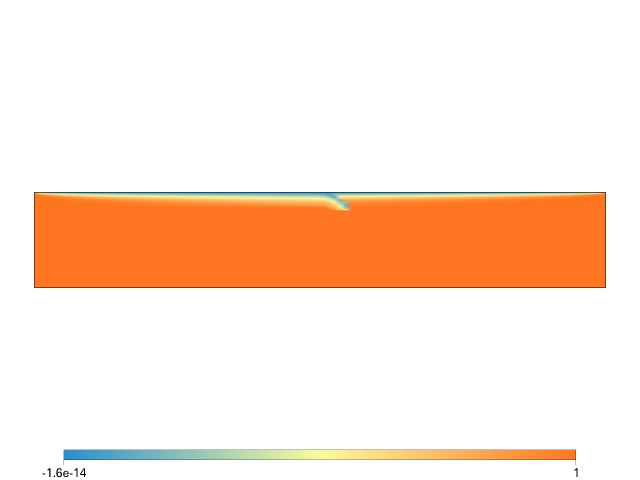

In [34]:
fig= glucifer.Figure(quality=3)
fig.append( glucifer.objects.Surface(mesh,temperatureField))
#fig.append( glucifer.objects.Surface(mesh,pressureField))


#fig.append( glucifer.objects.Points(gSwarm,temperatureField ))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()
##
#fig.save_database('test.gldb')
#fig.save_image('test.png')


In [35]:
#ageFn.evaluate(mesh).max()/(3600*24*365.)

Boundary conditions
-------

In [35]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]

VelBCs = mesh.specialSets["Empty"]



if md.velBcs:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (ndp.subzone - 0.05*md.aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*md.aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (ndp.subzone + 0.05*md.aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*md.aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if md.velBcs:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )




if periodic[0] == True:
    if md.velBcs:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [36]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Swarm setup
-----


In [37]:
###########
#Material Swarm and variables
###########

#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
ageVariable = gSwarm.add_variable( dataType="double", count=1 )


#these lists  are part of the checkpointing implementation
varlist = [materialVariable,  ageVariable]
varnames = ['materialVariable',  'ageVariable']

In [38]:
mantleIndex = 0
crustIndex = 1
harzIndex = 2
airIndex = 3



if checkpointLoad:
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=int(md.ppc))
    gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    materialVariable.data[:] = mantleIndex
    #tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    ageVariable.data[:] = -1

    #Set initial air and crust materials (allow the graph to take care of everything else)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < ndp.MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

In [39]:
###########
#Little swarm to track subduction zone, ridge location
###########
swarmPlateBoundary = uw.swarm.Swarm( mesh=mesh )

swarmCoords = np.array([ [ndp.subzone,1.], [ndp.lRidge,1.],[ndp.rRidge,1.]])


swarmPlateBoundary.add_particles_with_coordinates(swarmCoords)

array([0, 1, 2], dtype=int32)

###########
#This block sets up a checkboard layout of passive tracers
###########

square_size = 0.1
xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [40]:
##############
#Set the initial particle age for particles above the critical depth; 
#only material older than crustageCond will be transformed to crust / harzburgite
##############

ageVariable.data[:] = 0. #start with all zero
ageVariable.data[:] = ageFn.evaluate(gSwarm)/sf.SR
crustageCond = 8e6*(3600.*365.*24.)/sf.SR #set inital age above critical depth. (x...Ma)



ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable),  #In the main loop we add ageVariable + dt here
                  (True, 0.) ]
                 
#apply conditional 
ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)

ageDT = 0.#this is used in the main loop for short term time increments

In [41]:
##############
#Here we set up a directed graph object that we we use to control the transformation from one material type to another
##############

#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#Need a list of all material indexes (safer in parallel)
material_list = [0,1,2,3]

if not checkpointLoad:
    materialVariable.data[:] = 0 #Initialize to zero 

#Setup the graph object
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#Now set the conditions for transformations

hs = 2e3/dp.LS  #add some hysteresis to the depths of transition

#... to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((harzIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, ndp.TOPOHEIGHT + hs)

#... to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
#DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, ndp.subzone + 4.*ndp.MANTLETOCRUST) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, ndp.subzone) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)



DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
DG.add_transition((harzIndex,crustIndex), xFn, operator.lt, ndp.subzone) #This one sets no crust on the upper plate
DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)

#... to Harzbugite
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.lt, ndp.HARZBURGDEPTH)
#DG.add_transition((mantleIndex,harzIndex), depthFn, operator.gt, ndp.MANTLETOCRUST)
DG.add_transition((mantleIndex,harzIndex), ageVariable, operator.gt, crustageCond) #Note we can mix functions and swarm variabls


#... to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0.)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. )
DG.add_transition((harzIndex,airIndex), depthFn, operator.lt, 0. )




In [42]:
#CRUSTTOMANTLE, HARZBURGDEPTH, 0. + 7.*MANTLETOCRUST

In [43]:
ndp.MANTLETOCRUST

0.002758620689655172

In [44]:
##############
#For the slab_IC, we'll also add a crustal weak zone following the dipping perturbation
##############

if checkpointLoad != True:
    if not md.symmetricIcs:
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            if gSwarm.particleCoordinates.data[particleID][1] < 0.:
                materialVariable.data[particleID] = airIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - ndp.maxDepth) and
                Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = crustIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - ndp.maxDepth) and
                Hc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = harzIndex

In [45]:
#DG.remove_edges_from([(mantleIndex,crustIndex)])
#DG.remove_edges_from([(harzIndex,crustIndex)])


In [46]:
#DG.build_condition_list(materialVariable)
#print(len(DG.condition_list))
#DG.condition_list

In [47]:
#DG.edges()
#DG.build_condition_list(materialVariable)

In [48]:
##############
#This is how we use the material graph object to test / apply material transformations
##############

if not checkpointLoad:

    DG.build_condition_list(materialVariable)

    for i in range(1): #Need to go through a number of times
        materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [49]:
fig= glucifer.Figure(quality=3)

fig.append( glucifer.objects.Points(gSwarm ,materialVariable ))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()
##
#fig.save_database('test.gldb')

## Fault stuff



In [50]:
from unsupported_dan.interfaces.marker2D import markerLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection

/workspace/2dthermalslabs/kaplan/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
/workspace/2dthermalslabs/kaplan/unsupported_dan/faults/__init__.py:9: UserWarning: 

The fault module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [51]:
def copy_markerLine2D(ml, thickness=False, ID=False):
    
    """
    
    """
    if not thickness:
        thickness = ml.thickness
    if not ID:
        ID = -1*ml.ID
    new_line = markerLine2D(mesh, velocityField, [], [], thickness,  ID)
    if ml.swarm.particleCoordinates.data.shape[0] > 0:
        new_line.swarm.add_particles_with_coordinates(ml.swarm.particleCoordinates.data.copy())
        
    new_line.rebuild()
    return new_line

In [52]:
###########
#Initial Coordinates for inerfaces and faults
###########

#subduction fault
introPoint = ndp.subzone - abs(ndp.subzone - ndp.lRidge)/2. #half way between ridge and Sz
faultthickness = ndp.MANTLETOCRUST #initialise fault at bottom of the crust
nfault = 1000
faultCoords =np.zeros((nfault, 2))

reducedRocM = ndp.roc  - faultthickness
xlimslab = reducedRocM*math.cos(math.pi*(90. - dp.theta)/180)
faultCoords[:, 0] = np.linspace(introPoint, ndp.subzone + xlimslab, nfault) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(faultCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < ndp.subzone:
        faultCoords[index[0], 1] = MAXY - faultthickness #This bit for the plate 
        
    else:
        faultCoords[index[0], 1] = (MAXY - (faultthickness) - (reducedRocM - ( math.sqrt((reducedRocM**2 - (xval-ndp.subzone)**2)))))
        
    
faultCoords = faultCoords[faultCoords[:,1] > (MAXY - ndp.maxDepth)] #kill any deeper than cutoff


#surface tracer interface:
surfaceCoords =np.ones((nfault, 2))*1.
surfaceCoords[:,0] = np.linspace(MINX, MAXX, nfault)





In [53]:
#Initiaze the swarms in a 
fault  = fault2D(mesh, velocityField, [], [], faultthickness, 0., 0., crustIndex)
surface  = fault2D(mesh, velocityField, [], [], ndp.StALS, 0., 0., airIndex)
#slab_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], 1e9/dp.LS, crustIndex)   #Note very large fault thickness 

fault_coll = fault_collection([fault])

#Initiaze the swarms in a 
#fault_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], faultthickness, 0.0, 0.0, crustIndex)
#surface_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], ndp.StALS, 0.0, 0.0, airIndex)
#slab_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], 1e9/dp.LS, 0.0, 0.0, crustIndex)   #Note very large fault thickness

#These lists are used to checkpoint the marker lines, similar to the swarm variables.        
interfaces = []
interfaces.append(fault)
interfaces.append(surface)
interfacenames = ['fault_seg', 'surface_seg']


#If restarting, load the swarms from file Interfaces are just swarms, so should be fine to rely on parallel h5 machinery here
if checkpointLoad:
    for ix in range(len(interfaces)):
        tempname = interfacenames[ix]
        interfaces[ix].swarm.load(os.path.join(checkpointLoadDir,  tempname + ".h5"))

#otherwise add the point from at the initial locations
else:
    fault.add_points(faultCoords[:, 0], faultCoords[:, 1])
    surface.add_points(surfaceCoords[:, 0], surfaceCoords[:, 1])
    #slab_seg.add_points(slabCoords[:, 0], slabCoords[:, 1]) 
    

#rebuild the fault, necessary to swicth off empty flag., if starting fom checkpoint
    
fault.rebuild()
surface.rebuild()


In [54]:
#Add variables to the surface swarm
surfaceVelx = surface.swarm.add_variable( dataType="float", count=1 )
surfaceVelx.data[...] = velocityField[0].evaluate(surface.swarm)

In [55]:
#Add the necessary swarm variables

proximityVariable      = gSwarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = gSwarm.add_variable( dataType="float", count=1 )
directorVector   = gSwarm.add_variable( dataType="double", count=2)

directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0

In [56]:
#inform the mesh of the fault

sd, pts0 = fault.compute_signed_distance(gSwarm.particleCoordinates.data, distance=w0)
sp, pts0 = fault.compute_marker_proximity(gSwarm.particleCoordinates.data)

proximityVariable.data[np.logical_and(sd<0,sp == fault.ID)] = sp[np.logical_and(sd<0,sp == fault.ID)]

dv, nzv = fault.compute_normals(gSwarm.particleCoordinates.data)
directorVector.data[nzv] = dv[nzv]




edotn_SFn, edots_SFn = fault_coll.global_fault_strainrate_fns(velocityField, directorVector, proximityVariable)


In [57]:


# Call the Fault helper functions to initialize this info on the main material swarm
    
#update_swarm_from_faults(surface_seg, proximityVariable, directorVector, signedDistanceVariable)
#mask_materials(surface_seg, airIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

#update_swarm_from_faults(fault_seg, proximityVariable, directorVector, signedDistanceVariable)
#mask_materials(fault_seg, crustIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

#Also switch off proximity beneath ndp.CRUSTVISCUTOFF depth
#proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0. 

# These should be general enough not to need updating when the faults move etc..
#ie they should update as the fields/functions/swarm variables they are built on update
#edotn_SFn, edots_SFn = fault_strainrate_fns(interfaces, velocityField, directorVector, proximityVariable)

In [58]:
## Take a look at the locations of the materials

#Note we only use this mesh director for visualizing the directorVector (vector-on-swarm viewing not suppoted yet)
#meshDirector = uw.mesh.MeshVariable( mesh, 2 )
#projectDirector = uw.utils.MeshVariable_Projection( meshDirector, directorVector, type=1 )
#projectDirector.solve()    

figMaterials = glucifer.Figure( figsize=(1200,400))

#Plot swarm associated with each fault
figMaterials.append( glucifer.objects.Points(fault.swarm, colours="Black Black", pointSize=2.0, colourBar=False) )


#plot mesh director viz. guy
#figMaterials.append( glucifer.objects.VectorArrows(mesh, meshDirector, scaling=.08, 
#                                               resolutionI=100, resolutionJ=20, opacity=0.25) )


#Proximity variable - this is the colour
figMaterials.append( glucifer.objects.Points(gSwarm, proximityVariable, 
                                             pointSize=5.0,  opacity=0.75) )


#signedDistanceVariable - this variable goes to zero where the proximity cutoff is
#note that it's signed...faults have a direction
#figMaterials.append( glucifer.objects.Points(gSwarm, signedDistanceVariable, 
#                                             pointSize=2.0))

#Add mesh
#figMaterials.append( glucifer.objects.Mesh(mesh, opacity=0.1) )

#figMaterials.show()
#figMaterials.save_database('test.gldb')

Rheology
-----



In [59]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [60]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [61]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############
omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


#Note Because we're not using the pressure term, creep values will be unrealistically low at higher temps. 
#However this adpatation of the flow law gives us a nearly iso-viscous mantle, and a consistent viscosity (eta(T)) profile in the lithsphere
dfScale = (math.exp(ndp.Edf/(1. + ndp.TS) ))
diffusion = safe_visc((1./dfScale)*fn.math.exp(ndp.Edf / (temperatureField + ndp.TS)))

##Define the Plasticity
ys =  ndp.cm + (depthFn*ndp.fcmd)
ysMax = 10e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = ysf/(2.*(strainRate_2ndInvariant))

##Crust rheology
crustys =  ndp.cc + (depthFn*ndp.fccd) #only weakened cohesion is discussed, not fc
crustvisc = crustys/(2.*(strainRate_2ndInvariant)) 




In [62]:
#fig2= glucifer.Figure()
#fig2.append( glucifer.objects.Surface(mesh, diffusion, logScale=True))
#fig2.show()

In [63]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############


#combined rheology    
finalviscosityFn  = fn.branching.conditional([(depthFn < ndp.LOWMANTLEDEPTH, safe_visc(fn.misc.min(diffusion, yielding))),
                                  (True, safe_visc(safe_visc(diffusion*ndp.low_mantle_visc_fac)))])


crustviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustvisc), ndp.eta_max_crust)

if ndp.eta_max_crust == ndp.eta_min_crust: #If these are equal, set to constant visc. 
    crustviscosityFn = fn.misc.constant(ndp.eta_min_crust)
    


finalcrustviscosityFn  = fn.branching.conditional([(depthFn < ndp.CRUSTVISCUTOFF, crustviscosityFn),
                                                     (True, finalviscosityFn)])

Stokes system setup
-----


In [64]:
buoyancyFn =  ndp.RA*temperatureField


In [65]:
densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA,
                                    crustIndex:buoyancyFn, 
                                    mantleIndex:buoyancyFn,
                                    harzIndex:buoyancyFn} )

In [66]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [67]:
if md.PIC_integration:
    stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=diffusion, 
                              fn_bodyforce=buoyancyFn,
                              swarm=gSwarm)
    

else:
    stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=diffusion, 
                              fn_bodyforce=buoyancyFn )

/root/underworld2/underworld/systems/_stokes.py:70: UserWarning: 'swarm' paramater has been renamed to 'voronoi_swarm'. Please update your models. 'swarm' parameter will be removed in the next release.
  "'swarm' parameter will be removed in the next release.")


In [68]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

In [69]:
viscosityMapFn1 = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:finalcrustviscosityFn,
                                    mantleIndex:finalviscosityFn,
                                    harzIndex:finalviscosityFn,
                                    airIndex:ndp.Steta_n} )


delta_Steata2 = ndp.Steta_n - ndp.Steta_s
delta_eta_fault = 0.

if md.subductionFault:  
    if ndp.eta_min_fault == ndp.eta_min_fault:#Transverse rheology is isoviscous
        delta_eta_fault = fn.misc.min(0.999, fn.misc.max (0.,   ndp.eta_min_crust - ndp.eta_min_fault))       
        
    else:
        #Transverse viscosity is related the Mohr-Coulomb criterion
        delta_eta_fault = fn.misc.min(0.999, fn.misc.max (0., 
        viscosityMapFn1 - ((edotn_SFn*viscosityMapFn1 + ndp.fcfd * pressureField)  + ndp.cf)/edots_SFn))
   

In [70]:
# This one maps to my fault-proximity variable (which also picks only materialV)
viscosityMapFn2    = { 0: 0.0, 
                           1: delta_eta_fault, 
                           3: delta_Steata2
                       }
    

viscosityMapFn2  = fn.branching.map( fn_key = proximityVariable, 
                                           mapping = viscosityMapFn2)

In [71]:
#orientation = -1.*90. * math.pi / 180.0  #vertical
#math.cos(orientation), math.sin(orientation)

In [72]:
#md.subductionFault

In [73]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn1

if md.stickyAir or md.subductionFault:
    stokesPIC.fn_viscosity2 = viscosityMapFn2
    stokesPIC._fn_director   = directorVector


In [74]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 2.9650e-01
Pressure solve time: 2.5738e-02
Velocity solve time: 3.0068e-01 (backsolve)
Total solve time   : 6.7030e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [75]:
#Check which particles are yielding

yieldingCheck.data[:] = 0
yieldconditions = [ ( diffusion > yielding , 1), 
               ( True                                           , 0) ]
# use the branching conditional function to set each particle's index
yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [77]:
#Set up a swarm Stress function

swarmStressFn = 2.*stokesPIC.fn_viscosity*strainRate_2ndInvariant

In [78]:
sym_strainRate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )


eig1       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )

eig2       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )


meshVisc = uw.mesh.MeshVariable( mesh, 1)
projectGuy = uw.utils.MeshVariable_Projection(meshVisc, viscosityMapFn1, type=0 )
projectGuy.solve() 

In [79]:
ssr = sym_strainRate.evaluate(mesh)


for ti, val in enumerate(eig1.data):
    eigVals, eigVex= np.linalg.eigh(np.array([[ssr[ti][0],ssr[ti][2]],[ssr[ti][2],ssr[ti][1]]]), UPLO='U')
    #eig1.data[ti] = meshVisc.data[ti]*eigVals[0]*eigVex[0]
    #eig2.data[ti] = meshVisc.data[ti]*eigVals[1]*eigVex[1]
    eig1.data[ti] = eigVex[0]
    eig2.data[ti] = eigVex[1]

In [80]:
#fig.save_database('test.gldb')

## Polar stress tensor

In [81]:
from scipy.spatial import cKDTree as kdTree


def nn_evaluation(fromSwarm, _data, n=1, weighted=False):

    """
    This function provides nearest neighbour information for uw swarms,
    given the "_data", whcih could be the .data handle of a mesh or a swarm, this function returns the indices of the n nearest neighbours in "fromSwarm"
    it also returns the inverse-distance if weighted=True.

    The function works in parallel.   

    The arrays come out a bit differently when used in nearest neighbour form
    (n = 1), or IDW: (n > 1). The examples belowe show how to fill out a swarm variable in each case.


    Usage n = 1:
    ------------
    ix, weights = nn_evaluation(swarm, fault.swarm, n=n, weighted=False)
    toSwarmVar.data[:][:,0] =  fromSwarmVar.evaluate(fromSwarm)[_ix][:,0]

    Usage n > 1:
    ------------
    ix, weights = nn_evaluation(swarm, fault.swarm, n=n, weighted=False)
    toSwarmVar.data[:][:,0] =  np.average(fromSwarmVar.evaluate(fromSwarm)[ix][:,:,0], weights=weights, axis=1)

    """ 


    #print("fromSwarm data shape", fromSwarm.particleCoordinates.data.shape)

    if len(_data) > 0: #this is required for safety in parallel

        #we rebuild the tree as we assume the fromSwarm is being advected
        fromSwarm.tree = kdTree(fromSwarm.particleCoordinates.data)
        tree = fromSwarm.tree
        d, ix = tree.query(_data, n)
        if n == 1:
            weights = np.ones(_data.shape[0])
        elif not weighted:
            weights = np.ones((_data.shape[0], n))*(1./n)
        else:
            weights = (1./d[:])/(1./d[:]).sum(axis=1)[:,None]
        return ix,  weights
    else:
        return  np.empty(0., dtype="int"),  np.empty(0., dtype="int")

#construct an atan2 function, for angle around origin 

origin = (ndp.subzone, 1. - ndp.roc)

xrel = coordinate[0] - origin[0]
yrel = coordinate[1] - origin[1]

yoverx = yrel/xrel
xeq0 = operator.and_(xrel + 1e-20 > 0., xrel - 1e-20 < 0. )
yeq0 = operator.and_(yrel + 1e-20 > 0., yrel - 1e-20 < 0. )


conditions = [ ( xrel > 0. ,                      fn.math.atan(yoverx) ),
               ( operator.and_(xrel < 0.,yrel >= 0. ) ,   fn.math.atan(yoverx) + np.pi),
               ( operator.and_(xrel < 0.,yrel < 0. ) ,     fn.math.atan(yoverx) - np.pi),
               ( operator.and_(xeq0, yrel > 0. ) ,     np.pi/2.),
               ( operator.and_(xeq0, yrel < 0. ) ,     -1.*np.pi/2.),
               ( operator.and_(xeq0, yrel == 0. ) ,     fn.math.atan(yoverx) - np.pi),
               ( True,                                    9999999.) ]

thetaField= fn.branching.conditional( conditions )


#make an Nx4 mesh variable to store a transformation matrix

#for notes on transformation, see
#http://www.brown.edu/Departments/Engineering/Courses/En221/Notes/Polar_Coords/Polar_Coords.htm
#2.7 Converting tensors between Cartesian and Spherical-Polar bases

#Note that this is NOT how uw2 stores the tensor components
poltoCart    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=4 )
#######        ##############
# 0 1 #   ===> # cosX sinX #      ===> Q
# 2 3 #        # -sinX  cosX #
#######        ##############

#Set the elements of this guy
poltoCart.data[:,0] = np.cos(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,1] = np.sin(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,2] = -1.*np.sin(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,3] = np.cos(thetaField.evaluate(mesh)[:,0])

#Set up a nearest-neighbour interpolation for the velocity field


ix, weights = nn_evaluation(gSwarm, mesh.data, n=3, weighted=False)
meshVisc = np.average(stokesPIC.fn_viscosity.evaluate(gSwarm)[ix][:,:,0], weights=weights, axis=1)

#Construct and populate the cartesian and polar stress tensors

#take uw2 2-D tensor components:

########        
# 0  2 #  
#[2] 1 #  
######## 

#and put them in to the form above

#######        
# 0 1 #  
# 2 3 #  
####### 

stressTensor = uw.mesh.MeshVariable( mesh, 4)
stressTensor.data[:,0] = 2.*meshVisc*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,0] 
stressTensor.data[:,1] = 2.*meshVisc*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,2] 
stressTensor.data[:,2] = 2.*meshVisc*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,2] 
stressTensor.data[:,3] = 2.*meshVisc*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,1] 


polarstressTensor = uw.mesh.MeshVariable( mesh, 4)

for i, val in enumerate(mesh.data):
    Q = poltoCart.data[i].reshape((2, 2))
    S = stressTensor.data[i].reshape((2, 2))
    RH = np.dot(S,Q.T)
    LH = np.dot(Q,RH)
    polarstressTensor.data[i] = np.ravel(LH)
    

#check that the tensor contaractions are the same
print(np.dot(polarstressTensor.data[1], polarstressTensor.data[1]))
print(np.dot(stressTensor.data[1], stressTensor.data[1]))

#Function to restrict the mesh eigenvector arrows to the lithosphere
tempMM = fn.view.min_max(temperatureField)
tempMM.evaluate(mesh)
TMAX = tempMM.max_global()

mantleconditions = [ (                                  operator.and_(temperatureField < 0.9*TMAX, operator.and_(xFn> ndp.lRidge,xFn< ndp.rRidge )), 1.),
                   (                                                   True , 0.) ]
restFn = fn.branching.conditional(mantleconditions)

fig1= glucifer.Figure(quality=3)


fig1.append( glucifer.objects.VectorArrows(mesh,eig1*restFn,arrowHead=0., scaling=1e-2, resolutionI=16*10, resolutionJ=16*2 ))
fig1.append( glucifer.objects.VectorArrows(mesh,eig2*restFn,arrowHead=0., scaling=1e-2, resolutionI=16*10, resolutionJ=16*2 ))

fig1.append( glucifer.objects.Surface(mesh,polarstressTensor[0], valueRange=[0.001, 1e6]))
fig1.append( glucifer.objects.Surface(mesh,polarstressTensor[1], valueRange=[0.001, 1e6]))
fig1.append( glucifer.objects.Surface(mesh,polarstressTensor[2], valueRange=[0.001, 1e6]))

#fig1.show()
fig1.save_database('test1.gldb')


fig2= glucifer.Figure(quality=3)



fig2.append( glucifer.objects.Surface(mesh,stressTensor[0],  valueRange=[0.001, 1e6]))
fig2.append( glucifer.objects.Surface(mesh,stressTensor[1], valueRange=[0.001, 1e6]))
fig2.append( glucifer.objects.Surface(mesh,stressTensor[2], valueRange=[0.001, 1e6]))

fig2.save_database('test2.gldb')


fig3= glucifer.Figure(quality=3)


fig3.append( glucifer.objects.Points(gSwarm,sym_strainRate[0]*stokesPIC.fn_viscosity,valueRange=[0.001, 1e6]  ))
fig3.append( glucifer.objects.Points(gSwarm,sym_strainRate[1]*stokesPIC.fn_viscosity,valueRange=[0.001, 1e6]  ))
fig3.append( glucifer.objects.Points(gSwarm,sym_strainRate[2]*stokesPIC.fn_viscosity,valueRange=[0.001, 1e6]  ))

fig3.save_database('test3.gldb')


Advection-diffusion System setup
-----

In [82]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

materialadvector= uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [83]:
#population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=int(md.ppc))

population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.006,splitThreshold=0.1,maxDeletions=int(md.ppc/5),maxSplits=int(md.ppc/5), aggressive=True,aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))

Analysis functions / routines
-----

Most of the metrics we want to calculate are one of:

* extrema of some field / function
* integral of some field / function
* average value of some function (integral divide by area)

In addition, we also want to be able to determine these metrics over some restricted part of the domain, where the restriction may either be due some value of a field, a material type, or something more arbitrary.

Much of he challenge lies in defining these restriction functions in an efficient and robust way (i.e they don't break down as the model evolves)

For volume integrals, and extrema, we build a hierarchy of restriction functions, each extending from the previous, until we have divided the domain into a number of sub regions of interest. 

In general, averages are found afterwards by combining the integral and the area of the relavent subregion

In [84]:
###################
#Volume Restriction functions
###################

#Level 1. Global
globRestFn = fn.misc.constant(1.)

#Level 2. Rock - air:
rockRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
rockRestFn.data[:] = 0.
rockRestFn.data[np.where(materialVariable.data[:] != airIndex)] = 1.
rockRestFn *= globRestFn #Add next level up in heirarchy


#Level 3. lithosphere - mantle:
tempMM = fn.view.min_max(temperatureField)
tempMM.evaluate(mesh)
TMAX = tempMM.max_global()
mantleconditions = [ (                                  operator.and_(temperatureField < 0.9*TMAX, operator.and_(xFn> ndp.lRidge,xFn< ndp.rRidge )), 1.),
                   (                                                   True , 0.) ]
lithRestFn = fn.branching.conditional(mantleconditions)
lithRestFn*=rockRestFn #Add next level up in heirarchy


#Level 4. lower plate - upper plate:


#This whole section simply builds a restriction Fn that separates the upper and lower plate 
#It's pretty cumbersome, and will need to advected, rebuilt
#can YOU think of a better way?
   
lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 )
lowerPlateRestFn.data[:] = 0.0
sd, pts0 = fault.compute_signed_distance(gSwarm.particleCoordinates.data, distance=w0)
sp, pts0 = fault.compute_marker_proximity(gSwarm.particleCoordinates.data, distance=w0)

lowerPlateRestFn.data[np.logical_and(sd>0,sp == fault.ID)] = sp[np.logical_and(sd>0,sp == fault.ID)]
lowerPlateRestFn *= lithRestFn #Add next level up in heirarchy
#The lowerPlateRestFn isn't working on restart - no idea why



#Level 5. hinge of lower plate:

hinge60Spatialconditions = [ (           operator.and_( (depthFn < (60e3/dp.LS)),  (xFn > ndp.subzone - 60e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge60RestFn = fn.branching.conditional(hinge60Spatialconditions)
hinge60RestFn*=lowerPlateRestFn #Add next level up in heirarchy



hinge180Spatialconditions = [ (           operator.and_( (depthFn < (180e3/dp.LS)),  (xFn > ndp.subzone - 180e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge180RestFn = fn.branching.conditional(hinge180Spatialconditions)
hinge180RestFn*=lowerPlateRestFn #Add next level up in heirarchy


#Level 6. crust/interface in hinge of lower plate:

interfaceRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
interfaceRestFn.data[:] = 0.
interfaceRestFn.data[np.where(materialVariable.data[:] == crustIndex)] = 1.
interfaceRestFn *= hinge60RestFn #Add next level up in heirarchy


In [85]:
respltconditions = [ 
                    (                                  hinge60RestFn*2. > rockRestFn*1., 1.),
                    (                                  lowerPlateRestFn*3. > hinge60RestFn*2. , 3.),
                    (                                  lithRestFn*5. > lowerPlateRestFn*3. , 4.),
                   (                                                   True , 0.) ]

respltFn = fn.branching.conditional(respltconditions )

In [95]:
figR= glucifer.Figure()
#figR.append( glucifer.objects.Points(gSwarm,respltFn))
figR.append( glucifer.objects.Points(gSwarm,lithRestFn))
#figR.append( glucifer.objects.Points(gSwarm,lowerPlateRestFn))
#figR.append( glucifer.objects.Points(gSwarm,hinge60RestFn))
#fig.append( glucifer.objects.Points(gSwarm,interfaceRestFn))
#figR.show()
#figR.save_database('lptest.gldb')

In [97]:
#figR.show()

In [93]:
###################
#Surface Restriction functions
###################

def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srRestFn = platenessFn(val = 0.1)

In [94]:
###################
#Setup any Functions to be integrated
###################

sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
vx = velocityField[0]
v2x = fn.math.dot(velocityField[0],velocityField[0])
sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))
dw = temperatureField*velocityField[1]
sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vd = 4.*viscosityMapFn1*sinner # there's an extra factor of 2, which is necessary because the of factor of 0.5 in the UW second invariant 
dTdZ = temperatureField.fn_gradient[1]



In [95]:
###################
#Create integral, max/min templates 
###################

def volumeint(Fn = 1., rFn=globRestFn):
    return uw.utils.Integral( Fn*rFn,  mesh )

def surfint(Fn = 1., rFn=globRestFn, surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)

def maxMin(Fn = 1.):
    #maxMin(Fn = 1., rFn=globRestFn
    #vuFn = fn.view.min_max(Fn*rFn) #the restriction functions don't work with the view.min_max fn yet
    vuFn = fn.view.min_max(Fn)
    return vuFn
    
   
    

In [96]:
#Setup volume integrals on different sub regions

##Whole rock domain

_areaintRock = volumeint(rockRestFn)
_tempintRock = volumeint(temperatureField, rockRestFn)
_rmsintRock = volumeint(sqrtv2,rockRestFn)
_dwintRock = volumeint(dw,rockRestFn)
_vdintRock = volumeint(vd,rockRestFn)

##Lith 

_areaintLith  = volumeint(lithRestFn)
_tempintLith  = volumeint(temperatureField, lithRestFn)
_rmsintLith  = volumeint(sqrtv2,lithRestFn)
_dwintLith  = volumeint(dw,lithRestFn)
_vdintLith  = volumeint(vd,lithRestFn)

##Lower plate

_areaintLower  = volumeint(lowerPlateRestFn)
_tempintLower  = volumeint(temperatureField, lowerPlateRestFn)
_rmsintLower  = volumeint(sqrtv2,lowerPlateRestFn)
_dwintLower = volumeint(dw,lowerPlateRestFn)
_vdintLower  = volumeint(vd,lowerPlateRestFn)

##Hinge lower plate

_areaintHinge180  = volumeint(hinge180RestFn)
_vdintHinge180  = volumeint(vd,hinge180RestFn)

_areaintHinge60  = volumeint(hinge60RestFn)
_vdintHinge60  = volumeint(vd,hinge60RestFn)


##Interface

_areaintInterface  = volumeint(interfaceRestFn)
_vdintInterface = volumeint(vd,interfaceRestFn)

In [97]:
#Setup surface integrals

_surfLength = surfint()
_rmsSurf = surfint(sqrtv2x)
_nuTop = surfint(dTdZ)
_nuBottom = surfint(dTdZ, surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])
_plateness = surfint(srRestFn)
_pressure = surfint(pressureField)

In [98]:
#Setup max min fns (at the moment, we can't pass restriction function to view.min_max, so we're limited to whole volume or surface extrema)

##Whole rock domain

#_maxMinVisc = maxMin(viscosityMapFn1)  #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVisc.evaluate(mesh)
#_maxMinStressInv = maxMin(2*viscosityMapFn1*strainRate_2ndInvariant) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinStress.evaluate(mesh)
#_maxMinVd = maxMin(vd) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVd.evaluate(mesh)


_maxMinVel = maxMin(velocityField) 
dummyFn = _maxMinVel.evaluate(mesh)

_maxMinSr = maxMin(strainRate_2ndInvariant) 
dummyFn = _maxMinSr.evaluate(mesh)


#Surface extrema
_maxMinVxSurf = maxMin(vx)
dummyFn = _maxMinVxSurf.evaluate(tWalls)


In [99]:
#Volume Ints
areaintRock = _areaintRock.evaluate()[0]
tempintRock = _tempintRock.evaluate()[0]
rmsintRock = _rmsintRock.evaluate()[0]
dwintRock = _dwintRock.evaluate()[0]
vdintRock = _vdintRock.evaluate()[0]
areaintLith = _areaintLith.evaluate()[0]
tempintLith = _tempintLith.evaluate()[0]
rmsintLith = _rmsintLith.evaluate()[0]
dwintLith = _dwintLith.evaluate()[0]
vdintLith = _vdintLith.evaluate()[0]
areaintLower = _areaintLower.evaluate()[0]
tempintLower = _tempintLower.evaluate()[0]
rmsintLower = _rmsintLower.evaluate()[0]
dwintLower = _dwintLower.evaluate()[0]
vdintLower = _vdintLower.evaluate()[0]
vdintHinge180 = _vdintHinge180.evaluate()[0]
areaintHinge180 = _areaintHinge180.evaluate()[0]
vdintHinge60 = _vdintHinge60.evaluate()[0]
areaintHinge60= _areaintHinge60.evaluate()[0]
vdintInterface = _vdintInterface.evaluate()[0]
areaintInterface= _areaintInterface.evaluate()[0]

#Surface Ints
surfLength = _surfLength.evaluate()[0]
rmsSurf = _rmsSurf.evaluate()[0]
nuTop = _nuTop.evaluate()[0]
nuBottom = _nuBottom.evaluate()[0]
plateness = _plateness.evaluate()[0]
pressureSurf = _pressure.evaluate()[0]

#Max mins
maxVel = _maxMinVel.max_global()
minVel = _maxMinVel.min_global() 
maxSr = _maxMinSr.max_global()
minSr = _maxMinSr.min_global()
maxVxsurf = _maxMinVxSurf.max_global()
minVxsurf = _maxMinVxSurf.min_global()

print(areaintRock)
print(tempintRock)
print(rmsintRock)
print(dwintRock)
print(vdintRock)
print(areaintLith)
print(tempintLith )
print(rmsintLith)
print(dwintLith)
print(vdintLith)
print(areaintLower)
print(tempintLower)
print(rmsintLower) 
print(dwintLower)
print(vdintLower)
print(vdintHinge60)
print(vdintHinge180)
print(vdintInterface)

print(surfLength)
print(rmsSurf)
print(nuTop)
print(nuBottom)
print(plateness)


print(maxVel)
print(minVel)
print(maxSr)
print(minSr)
print(maxVxsurf)
print(minVxsurf)

Viz.
-----

In [100]:
#Build a depth dependent mask for the vizualisation

depthVariable      = gSwarm.add_variable( dataType="float", count=1 )
depthVariable.data[:] = depthFn.evaluate(gSwarm)

vizVariable      = gSwarm.add_variable( dataType="int", count=1 )
vizVariable.data[:] = 0

for index, value in enumerate(depthVariable.data[:]):
    #print index, value
    if np.random.rand(1)**5 > value/(MAXY - MINY):
        vizVariable.data[index] = 1
        
del index, value    #get rid of any variables that might be pointing at the .data handles (these are!)

In [101]:
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Points(swarmPlateBoundary, pointSize=4))
    #figDb.append( glucifer.objects.Mesh(mesh))
    #figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    #figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
    figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
    
    #figDb.append( glucifer.objects.Points(gSwarm,viscMinVariable))
    figDb.append( glucifer.objects.Points(gSwarm, ageVariable))
    #figDb.append( glucifer.objects.Points(gSwarm, viscosityMapFn1, logScale=True))
    #figDb.append( glucifer.objects.Points(gSwarm, strainRate_2ndInvariant, logScale=True))
    #figDb.append( glucifer.objects.Points(gSwarm,temperatureField))
    #figDb.append( glucifer.objects.Points(gSwarm,pressureField))
    figDb.append( glucifer.objects.Points(fault.swarm, pointSize=3))
    
    
    #figRestrict= glucifer.Figure()
    #figRestrict.append( glucifer.objects.Points(gSwarm,respltFn))
    #figRestrict.append( glucifer.objects.Points(gSwarm,lithRestFn))
    #figRestrict.append( glucifer.objects.Points(gSwarm,lowerPlateRestFn))
    #figRestrict.append( glucifer.objects.Points(gSwarm,hinge180RestFn))
    #figRestrict.append( glucifer.objects.Points(gSwarm,interfaceRestFn))
    #figRestrict.append( glucifer.objects.Points(interfaces[0].swarm, colours="Blue Blue", pointSize=2.0, colourBar=False) )
    #figRestrict.append( glucifer.objects.Points(interfaces[1].swarm, colours="Red Red", pointSize=2.0, colourBar=False) )
    #figRestrict.append( glucifer.objects.Points(slab_seg.swarm, colours="Black Black", pointSize=2.0, colourBar=False) )

elif figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    store1 = glucifer.Store(fullpath + 'subduction1.gldb')
    store2 = glucifer.Store(fullpath + 'subduction2.gldb')
    store3 = glucifer.Store(fullpath + 'subduction3.gldb')
    store4 = glucifer.Store(fullpath + 'subduction4.gldb')


    figTemp = glucifer.Figure(store1,figsize=(300*np.round(md.aspectRatio,2),300))
    figTemp.append( glucifer.objects.Points(gSwarm,temperatureField, fn_mask=vizVariable))

    figVisc= glucifer.Figure(store2, figsize=(300*np.round(md.aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(gSwarm,viscosityMapFn1, logScale=True, valueRange =[1.,1e5], fn_mask=vizVariable))


    figMat= glucifer.Figure(store3, figsize=(300*np.round(md.aspectRatio,2),300))
    figMat.append(glucifer.objects.Points(gSwarm,materialVariable, fn_mask=vizVariable))
    figMat.append( glucifer.objects.VectorArrows(mesh,velocityField,resolutionI=int(16*md.aspectRatio), resolutionJ=16*2,  scaling=0.0005))
    figMat.append(glucifer.objects.Points(gSwarm,yieldingCheck, fn_mask=vizVariable))

    
    
    
    #figRest= glucifer.Figure(store4, figsize=(300*np.round(md.aspectRatio,2),300))
    #figRest.append( glucifer.objects.Points(gSwarm,respltFn))


In [102]:
#figTemp.show()

In [103]:
#matPoints = glucifer.objects.Points(gSwarm,materialVariable, fn_mask=vizVariable)
#figMat= glucifer.Figure(store3, figsize=(300*np.round(md.aspectRatio,2),300))
#figMat.append(matPoints )

**Miscellania**

In [104]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [105]:
##############
#These functions handle checkpointing
##############


#Subzone = ndp.subzone


def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        f_o.write((30*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone,ndp.lRidge, ndp.rRidge, realtime))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    
    #Save the parameters
    dict_list = [dp, sf, ndp, md] #if any of the dictionaries have changed, this list needs to be rebuilt
    save_pickles(dict_list, dict_names, path)
    
#Simple Checkpoint function for the faults / interfaces (markerLine2D)
def checkpoint3(step,  checkpointPath, interfaces,interfacenames ):
    path = checkpointPath + str(step)
    for ix in range(len(interfaces)):
        intf = interfaces[ix]
        intf.swarm.save(os.path.join(path,interfacenames[ix] + ".h5"))
    
    

In [106]:
def plate_infoFn(velocityField,xFn,  depthLimit, xsearchlim = 1.0, currentloc = 0.0, plateType='convergent'):
    """
    This functions is used to track the plate boundaries in 2D.
    It returns the x value of the max / min of the x velocity gradient.
    
    """
    
    #Restriction fucntion 
    restictionFn = fn.branching.conditional([(operator.and_(fn.math.abs(xFn - currentloc) < xsearchlim, depthFn < depthLimit) , 1.),                                       
                                             (True, 0.0)])
    
    #Normalised surface vel gradient
    normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

    
    plateFn0 = normgradV*restictionFn
    
    plateFn = fn.branching.conditional([(plateFn0 > 1e20, 0.),             #This attempts to fix inf values that appear at sidewalls                          
                                             (True, plateFn0)])
    
    extremFn = fn.view.min_max(plateFn)
    dummy = extremFn.evaluate(mesh)
    
    
    print(extremFn.min_global(), extremFn.max_global())

    #get global max
    if plateType == 'convergent':   
        testFn = fn.branching.conditional([(extremFn < extremFn.min_global() + 1e-10, coordinate[0]),                                       
                                             (True, (-9999999.))])
        extremFn2 = fn.view.min_max(testFn)
        dummy2 = extremFn2.evaluate(mesh)
        if extremFn2.max_global() == -9999999.:
            return currentloc
        else:
            return extremFn2.max_global()
    elif plateType == 'divergent':
        testFn = fn.branching.conditional([(extremFn > extremFn.max_global() - 1e-3, coordinate[0]),                                       
                                             (True, (-9999999.))])
        extremFn2 = fn.view.min_max(testFn)
        dummy2 = extremFn2.evaluate(mesh)
        if extremFn2.max_global() == -9999999.:
            return currentloc
        else:
            return extremFn2.max_global()
    else:
        raise ValueError('plateType should be one of convergent/divergent')

In [108]:
# initialise timer for computation
start = time.clock()


Main simulation loop
-----


In [1]:
#while step < 6:
while realtime < 0.0004:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    
    #remove drift /null space in pressure
    pressureField.data[:] -= pressureSurf/surfLength
    
    
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    materialadvector.integrate(dt)
    #advect any interfaces
    fault.advection(dt)
    
    
    
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP
                
    ################
    #Files output
    ################ 
    if (step % files_output == 0):
        
        gSwarm.update_particle_owners()
        
        #Save the fault swarm
        fnametemp1 = "faultSwarm" + "_" + str(step)
        fullpath1 = os.path.join(outputPath + "files/" + fnametemp1)
        fault.swarm.save(fullpath1)
        
        #build a metric swarm and save values
        #Copy the fault and jitter, this is the swarm we'll capture inteface details on 

        metricSwarm  = copy_markerLine2D(fault)
        
        #translate the metric swarm into desired location
        ds = ndp.MANTLETOCRUST/2.
        with metricSwarm.swarm.deform_swarm():
            metricSwarm.swarm.particleCoordinates.data[...] -= metricSwarm.director.data[...]*ds
            
        
        gSwarm.update_particle_owners()
        metricSwarm.swarm.update_particle_owners()
         
        comm.barrier()
        #build the arrays for nearest neighbour evaluation on the metric swarm
        _ix, _weights = nn_evaluation(gSwarm, metricSwarm.swarm.particleCoordinates.data, n=5, weighted=True)
        #_ix, _weights = nn_evaluation(gSwarm, metricSwarm.swarm, n=1, weighted=False)
        
        
        
        #set up some swarm variables
        interfaceSinv = metricSwarm.swarm.add_variable( dataType="float", count=1 )
        if len(metricSwarm.swarm.particleCoordinates.data) > 0:
            interfaceSinv.data[:] = strainRate_2ndInvariant.evaluate(metricSwarm.swarm)
        
        interfaceVisc = metricSwarm.swarm.add_variable( dataType="float", count=1 )
        if len(metricSwarm.swarm.particleCoordinates.data) > 0:
            interfaceVisc.data[:][:,0] = np.average(viscosityMapFn1.evaluate(gSwarm)[_ix][:,:,0], weights=_weights, axis=1)

    
        interfaceStress = metricSwarm.swarm.add_variable( dataType="float", count=1 )
        if len(metricSwarm.swarm.particleCoordinates.data) > 0:
            interfaceStress.data[:][:,0] = np.average(swarmStressFn.evaluate(gSwarm)[_ix][:,:,0], weights=_weights, axis=1)

        
        uw.barrier()
        #Save metric swarm and swarm vars. 
        fnametemp = "metricSwarm" + "_" + str(step) + '.h5'
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        metricSwarm.swarm.save(fullpath)
        #
        uw.barrier()
        fnametemp = "interfaceSinv" + "_" + str(step)+ '.h5'
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        interfaceSinv.save(fullpath)
        #
        uw.barrier()
        fnametemp = "interfaceVisc" + "_" + str(step) + '.h5'
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        interfaceVisc.save(fullpath)
        #
        uw.barrier()
        fnametemp = "interfaceStress" + "_" + str(step) + '.h5'
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        interfaceStress.save(fullpath)
        
        
        del metricSwarm, interfaceSinv, interfaceVisc,interfaceStress, _ix, _weights #now delete them
        
        #Now the surface x vels.
        surfaceVelx.data[...] = velocityField[0].evaluate(surface.swarm)
        fnametemp = "velxSurface" + "_" + str(step) + '.h5'
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        surfaceVelx.save(fullpath)

    ################
    #Fault / interface repair
    ################    
    #Any functions to do with repairing the interfaces should go here
    
                
    ################
    #Update the subduction zone / plate information
    ################ 
    
    comm.barrier()
    if (step % metric_output == 0):
        

        ndp.subzone = plate_infoFn(velocityField,xFn,  20e3/dp.LS, xsearchlim = 200e3/dp.LS, currentloc = ndp.subzone, plateType='convergent')
        ndp.lRidge = plate_infoFn(velocityField,xFn,  20e3/dp.LS, xsearchlim = 200e3/dp.LS, currentloc = ndp.lRidge, plateType='divergent')
        ndp.rRidge = plate_infoFn(velocityField,xFn,  20e3/dp.LS, xsearchlim = 200e3/dp.LS, currentloc = ndp.rRidge, plateType='divergent')

                
    ################
    # Calculate the Metrics
    ################
    if (step % metric_output == 0):
        ###############
        #Rebuild the restriction functions where necessary
        ###############
        
        #Lithosphere - mantle:
        tempMM = fn.view.min_max(temperatureField)
        tempMM.evaluate(mesh)
        TMAX = tempMM.max_global()
        mantleconditions = [ (                                  operator.and_(temperatureField < 0.9*TMAX, operator.and_(xFn> ndp.lRidge,xFn< ndp.rRidge )), 1.),
                   (                                                   True , 0.) ]
        lithRestFn = fn.branching.conditional(mantleconditions)
        lithRestFn*=rockRestFn #Add next level up in heirarchy
        
        #Lower plate
        
        lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 ) #weirdly we have to rebuild this one...
        lowerPlateRestFn.data[:] = 0.0
        sd, pts0 = fault.compute_signed_distance(gSwarm.particleCoordinates.data, distance=w0)
        sp, pts0 = fault.compute_marker_proximity(gSwarm.particleCoordinates.data, distance=w0)
        lowerPlateRestFn.data[np.logical_and(sd>0,sp == fault.ID)] = sp[np.logical_and(sd>0,sp == fault.ID)]
        lowerPlateRestFn *= lithRestFn #Add next level up in heirarchy
        
        #Hinge
        
        hinge60Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (60e3/dp.LS)),  (xFn > ndp.subzone - 60e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]
        hinge60RestFn = fn.branching.conditional(hinge60Spatialconditions)
        hinge60RestFn*=lowerPlateRestFn #Add next level up in hierarchy



        hinge180Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (180e3/dp.LS)),  (xFn > ndp.subzone - 180e3/dp.LS)), 1.),
                           (                                                   True , 0.) ]
        hinge180RestFn = fn.branching.conditional(hinge180Spatialconditions)
        hinge180RestFn*=lowerPlateRestFn #Add next level up in hierarchy
        
        ###############
        #Metrics
        ###############
        areaintRock = _areaintRock.evaluate()[0] #trivial except when using sticky air
        tempintRock = _tempintRock.evaluate()[0]
        rmsintRock = _rmsintRock.evaluate()[0]
        dwintRock = _dwintRock.evaluate()[0]
        vdintRock = _vdintRock.evaluate()[0]
        areaintLith = _areaintLith.evaluate()[0]
        tempintLith = _tempintLith.evaluate()[0]
        rmsintLith = _rmsintLith.evaluate()[0]
        dwintLith = _dwintLith.evaluate()[0]
        vdintLith = _vdintLith.evaluate()[0]
        areaintLower = _areaintLower.evaluate()[0]
        tempintLower = _tempintLower.evaluate()[0]
        rmsintLower = _rmsintLower.evaluate()[0]
        dwintLower = _dwintLower.evaluate()[0]
        vdintLower = _vdintLower.evaluate()[0]
        vdintHinge180 = _vdintHinge180.evaluate()[0]
        areaintHinge180 = _areaintHinge180.evaluate()[0]
        vdintHinge60 = _vdintHinge60.evaluate()[0]
        areaintHinge60= _areaintHinge60.evaluate()[0]
        vdintInterface = _vdintInterface.evaluate()[0]
        areaintInterface= _areaintInterface.evaluate()[0]
        #Surface integrals
        rmsSurf = _rmsSurf.evaluate()[0]
        nuTop = _nuTop.evaluate()[0]
        nuBottom = _nuBottom.evaluate()[0]
        plateness = _plateness.evaluate()[0]
        #extrema
        maxVel = _maxMinVel.max_global()
        minVel = _maxMinVel.min_global() 
        maxSr = _maxMinSr.max_global()
        minSr = _maxMinSr.min_global()
        maxVxsurf = _maxMinVxSurf.max_global()
        minVxsurf = _maxMinVxSurf.min_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((30*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone,ndp.lRidge, ndp.rRidge, realtime))
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        population_control.repopulate()   
        
        
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        
        #ReBuild the depth dependent mask for the vizualisation
        depthVariable      = gSwarm.add_variable( dataType="float", count=1 )
        depthVariable.data[:] = depthFn.evaluate(gSwarm)
        vizVariable      = gSwarm.add_variable( dataType="int", count=1 )
        vizVariable.data[:] = 0
        for index, value in enumerate(depthVariable.data[:]):
            #print index, value
            if np.random.rand(1)**5 > value/(MAXY - MINY):
                vizVariable.data[index] = 1
        del index, value    #get rid of any variables that might be pointing at the .data handles (these are!)
        
        #rebuild the yielding check
        yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)
        
        if figures == 'gldb':
            
            
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
           
            
        elif figures == 'store':      
            
            
        
            store1.step = step
            store2.step = step
            store3.step = step
            
            #Save figures to store
            fullpath = os.path.join(outputPath + "gldbs/")
            figVisc.save( fullpath + "Visc" + str(step).zfill(4))
            #figMech.save( fullPath + "Mech" + str(step).zfill(4))
            figTemp.save( fullpath + "Temp"    + str(step).zfill(4))
            figMat.save( fullpath + "Mat"    + str(step).zfill(4))
            #figRest.save( fullpath + "Rest"    + str(step).zfill(4))

        

        

    ################
    #Particle update
    ###############    
    #ageVariable.data[:] += dt #increment the ages (is this efficient?)
    ageDT += dt
    
    if step % swarm_update == 0:
        
        #Increment age stuff. 
        ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable + ageDT ),  #add ageDThere
                  (True, 0.) ]
        ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)        
        ageDT = 0. #reset the age incrementer
        
        
        #This is hardcoded to assume subduction is towards the right
        tempop = operator.lt

        #Update the relevant parts of the material graph
        #Remove and rebuild edges related to crust
        DG.remove_edges_from([(mantleIndex,crustIndex)])
        DG.add_edges_from([(mantleIndex,crustIndex)])
        DG.remove_edges_from([(harzIndex,crustIndex)])
        DG.add_edges_from([(harzIndex,crustIndex)])

        #... to crust
        DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
        DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, 0.5*ndp.lRidge) #No crust on the upper plate
        DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)

        DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
        DG.add_transition((harzIndex,crustIndex), xFn, tempop, 0.5*ndp.lRidge) #This one sets no crust on the upper plate
        DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)
        
        
        #Make sure to rebuild the condition list if you want changes to be applied
        DG.build_condition_list(materialVariable)
        
        comm.barrier()
    
    
        
        
        #Apply any materialVariable changes
        for i in range(2): #go through twice
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
        
        #Also update any information related to faults / interfaces:

        sd, pts0 = fault.compute_signed_distance(gSwarm.particleCoordinates.data, distance=w0)
        sp, pts0 = fault.compute_marker_proximity(gSwarm.particleCoordinates.data)

        proximityVariable.data[np.logical_and(sd<0,sp == fault.ID)] = sp[np.logical_and(sd<0,sp == fault.ID)]

        dv, nzv = fault.compute_normals(gSwarm.particleCoordinates.data)
        directorVector.data[nzv] = dv[nzv]

        proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0.
        
        #And add extra particles to interfaces as necessary
        #subduction fault
        introPoint = ndp.subzone - abs(ndp.subzone - ndp.lRidge)/2. #half way between ridge and Sz
        fault.add_points([introPoint],[MAXY - faultthickness])
        
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        checkpoint3(step,  checkpointPath, interfaces,interfacenames )
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?

    
f_o.close()
print 'step =',step

NameError: name 'realtime' is not defined

In [110]:
#vxTi = velocityField[0].evaluate(surface_nodes)
#vxIso = velocityFieldIso[0].evaluate(surface_nodes)
#%pylab inline
#fig, axes = plt.subplots(figsize=(16,4))
#axes.plot(vxTi)
#axes.plot(vxIso)


#fig, axes = plt.subplots(figsize=(16,4))
#axes.plot(vxTi)
#axes.plot(surface_xs, vxTi - vxIso)
#fig.savefig('Ti_minus_Iso.png')
#plt.title('surface velocity residual - T. Iso minus Iso. weak zone')


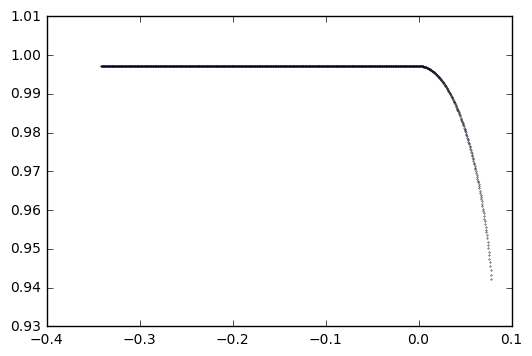

In [249]:
test = fault.swarm.particleCoordinates.data.copy()
np.random.shuffle(test)

fxs = test[:,0]
fys = test[:,1]

plt.scatter(fxs,
           fys, s= 0.1)

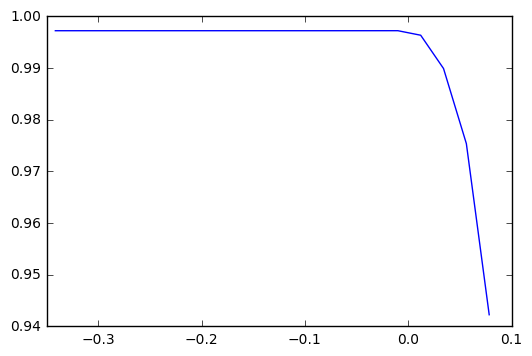

In [250]:
from scipy.interpolate.rbf import Rbf

testXs = np.linspace(fxs.min(),fxs.max(), 20 )

rbf_adj = Rbf(fxs, fys, function='linear')
lin_bimes = rbf_adj(testXs)
plot3 = plt.plot(testXs, lin_bimes, '-', label='lin')
#plt.scatter(fxs,fys, s= 0.1)